## Load data


In [117]:
import numpy as np 
import pandas as pd 
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
BASE_IMG_PATH=os.path.join('hecktor-master','data','resampled')
BATCH_SIZE = 5
INPUT_SHAPE = (144,144,144,2)

In [5]:
glob(os.path.join(BASE_IMG_PATH,'*'))


['hecktor-master\\data\\resampled\\CHGJ007_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ007_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ007_pt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ008_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ008_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ008_pt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ010_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ010_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ010_pt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ013_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ013_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ013_pt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ015_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ015_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ015_pt.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ016_ct.nii.gz',
 'hecktor-master\\data\\resampled\\CHGJ016_ct_gtvt.nii.gz',
 'hecktor-master\\data\\resampled\\

In [60]:
# show some of the files
all_ct_images= glob(os.path.join(BASE_IMG_PATH,'*ct.nii.gz'))
all_pt_images = [x.replace('ct.nii.gz', 'pt.nii.gz') for x in all_ct_images]
all_mask_images = [x.replace('ct.nii.gz', 'ct_gtvt.nii.gz') for x in all_ct_images]

rand_index = np.random.randint(0, len(all_ct_images))
print(len(all_ct_images),' matching files found:',all_ct_images[rand_index], all_pt_images[rand_index])
print(len(all_mask_images),' matching files found:',all_ct_images[rand_index], all_mask_images[rand_index])


36  matching files found: hecktor-master\data\resampled\CHGJ017_ct.nii.gz hecktor-master\data\resampled\CHGJ017_pt.nii.gz
36  matching files found: hecktor-master\data\resampled\CHGJ017_ct.nii.gz hecktor-master\data\resampled\CHGJ017_ct_gtvt.nii.gz


(141, 141, 144)


Text(0.5, 1.0, 'Mask')

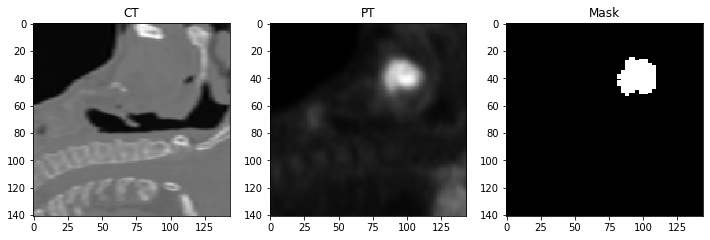

In [84]:
%matplotlib inline
try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')
    
test_ct=np.asarray(nib.load(all_ct_images[rand_index]).dataobj)
test_pt=np.asarray(nib.load(all_pt_images[rand_index]).dataobj)
test_mask=np.asarray(nib.load(all_mask_images[rand_index]).dataobj)
print(test_ct.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))

ax1.imshow(test_ct[test_ct.shape[0]//2], cmap = 'gray')
ax1.set_title('CT')
ax2.imshow(test_pt[test_pt.shape[0]//2], cmap = 'gray')
ax2.set_title('PT')
ax3.imshow(test_mask[test_mask.shape[0]//2], cmap = 'gray')
ax3.set_title('Mask')

In [120]:
def make144(image):
    new_image = skimage.transform.resize(image, (144,144,144), mode= 'edge')
    return new_image

def preprocess(image):
    if image.shape != (144,144,144):
        image = make144(image)
    new_image = (image - image.mean())/image.std()
    
    return new_image[..., np.newaxis]
print(test_pt.max(), test_pt.min(),test_pt.shape)
new_img = preprocess(test_pt)
print(new_img.max(), new_img.min(),new_img.shape)

21.06431 -0.051830534 (141, 141, 144)
10.510409 -0.6548927 (144, 144, 144, 1)


In [121]:
data = preprocess(test_pt)
data = np.concatenate((data, preprocess(test_pt)), -1)
data.shape

(144, 144, 144, 2)

In [122]:
#check if ct, pt, mask have same numbers.

from sklearn.model_selection import train_test_split

if not len(all_ct_images) == len(all_pt_images) == len(all_mask_images):
    print(len(all_ct_images), len(all_pt_images), len(all_mask_images))
    raise ValueError('ct,pt,mask number not match')

data_list_index = range(len(all_ct_images))
train_data_list, val_data_list = train_test_split(data_list_index, test_size = 0.2, random_state = 1)


In [ ]:
def tf_data_generator(file_list, batch_size = 2):
    i = 0
    while True:
        if i*batch_size >= len(file_list):  
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:
                _ct=np.asarray(nib.load(all_ct_images[file]).dataobj)
                _pt=np.asarray(nib.load(all_pt_images[file]).dataobj)
                _mask=np.asarray(nib.load(all_mask_images[file]).dataobj)
                
                img = preprocess(_ct)
                img = np.concatenate((img, preprocess(_pt)), -1)
                data.append(img) 
                
                _mask = make144(_mask)
                labels.append(_mask)
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1
            
batch_size = BATCH_SIZE

#tf_data_generator(train_data_list)


train_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [train_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144)))        

valid_dataset = tf.data.Dataset.from_generator(tf_data_generator,args= [val_data_list, batch_size],
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes = ((None,144,144,144,2),(None,144,144,144))) 

#test the data generator
num = 0
for data, labels in train_dataset:
    print(data.shape, labels.shape)
    print(labels.shape)

    num = num + 1
    if num > 7: break
        
for data, labels in valid_dataset:
    print(data.shape, labels.shape)
    print(labels.shape)

    num = num + 1
    if num > 7: break

(5, 144, 144, 144, 2) (5, 144, 144, 144)
(5, 144, 144, 144)
(5, 144, 144, 144, 2) (5, 144, 144, 144)
(5, 144, 144, 144)
(5, 144, 144, 144, 2) (5, 144, 144, 144)
(5, 144, 144, 144)
(5, 144, 144, 144, 2) (5, 144, 144, 144)
(5, 144, 144, 144)


## Densely 3D Unet

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling3D
from tensorflow.keras.layers import Conv3D, Conv3DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv3D(16, kernel_size=(3, 3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    #t = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same', data_format='channels_last')(t)
    t = Conv3D(nb_features, kernel_size=(1, 1, 1),strides=(2,2,1), padding='same', data_format='channels_last')(t)
    
    return t

def Tiramisu3D(layer_per_block, n_pool=4, growth_rate=16):
    input_layer = Input(shape=INPUT_SHAPE)
    t = Conv3D(48, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv3DTranspose(keep_nb_features, strides=(2,2,1), kernel_size=(3, 3, 3), padding='same', data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv3D(12, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('softmax')(t)
    return Model(inputs=input_layer, outputs=output_layer)

layer_per_block =  [3, 4, 5, 6, 7, 6, 5, 4, 3]
#layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
tiramisu = Tiramisu3D(layer_per_block)